# **Laboratorio 3:** MLFlow

MLFLow es una plataforma de código abierto para administrar el ciclo de vida de ML, incluida la experimentación, la reproducibilidad, la implementación y un registro de modelo central. Actualmente, MLFLow ofrece cuatro componentes:


<img src="https://images.datacamp.com/image/upload/v1666023613/M_Lflow_Components_64d5714287.png" width="70%">

<img src="https://www.databricks.com/sites/default/files/2020/04/databricks-adds-access-control-to-mlflow-model-registry_01.jpg" width="70%">


Ref. https://www.datacamp.com/tutorial/mlflow-streamline-machine-learning-workflow

## 1. Crear un entorno Conda

Ejecutar los siguientes comandos en la terminal. Se sugiere asegurarse de que conda esté instalado: 

1. `conda create -n mlops python=3.9 ipykernel`
creará un env conda llamado mlops e instalará la versión 3.9 de python y un ipykernel dentro de este entorno

2. Activar el ambiente
`conda activate mlops`

3. Agregar el entorno recién creado al notebook como kernel
`python -m ipykernel install --user --name=mlops`

4. Instalar los notebooks de jupyter dentro del entorno
`pip install notebook`

5. Instalar todas las dependencias requeridas para ejecutar el presente notebook

* `pip install pandas`
* `pip install numpy`
* `pip install scikit-learn`
* `pip install imblearn`
* `pip install matplotlib`
* `pip install mlflow`

Finalmente, abrir este notebook usando el siguiente comando: (desde el prompt de anaconda dentro del entorno de conda)

`jupyter notebook`


Se sugiere asegurarse que versión de Python esta usado, desde el notebook actual.

In [1]:
import sys
print(sys.executable)

C:\Users\hp\anaconda3\envs\mlops\python.exe


In [2]:
!python --version

Python 3.9.7


## 2. Machine Learning

En la siguiente sección se crearan funciones para todos los pasos involucrados en el ciclo de vida completo de entrenamiento del modelo. 

In [38]:
# Importar librerías
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from imblearn.over_sampling import SMOTE

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score,log_loss, confusion_matrix, roc_curve, ConfusionMatrixDisplay, RocCurveDisplay
from sklearn.model_selection import RandomizedSearchCV

import mlflow

In [39]:
def load_data(path):
    data = pd.read_csv(path)
    return data

Descargar el dataset desde la siguiente dirección: 
https://drive.google.com/file/d/11vWjRhPA9lYnK7oQmV4DX4h6TjAoOTvx/view?usp=sharing
y ubicarlo al lado del presente notebook. 

In [40]:
data = load_data('banking.csv')
data.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed,y
0,44,blue-collar,married,basic.4y,unknown,yes,no,cellular,aug,thu,...,1,999,0,nonexistent,1.4,93.444,-36.1,4.963,5228.1,0
1,53,technician,married,unknown,no,no,no,cellular,nov,fri,...,1,999,0,nonexistent,-0.1,93.200,-42.0,4.021,5195.8,0
2,28,management,single,university.degree,no,yes,no,cellular,jun,thu,...,3,6,2,success,-1.7,94.055,-39.8,0.729,4991.6,1
3,39,services,married,high.school,no,no,no,cellular,apr,fri,...,2,999,0,nonexistent,-1.8,93.075,-47.1,1.405,5099.1,0
4,55,retired,married,basic.4y,no,yes,no,cellular,aug,fri,...,1,3,1,success,-2.9,92.201,-31.4,0.869,5076.2,1


In [41]:
print("Número total de registros:", len(data))
print("Conteo de suscripciones confirmadas:", len(data.loc[data['y']==1])) 
print("Conteo de no suscripciones:", len(data.loc[data['y']==0])) 

Número total de registros: 41188
Conteo de suscripciones confirmadas: 4640
Conteo de no suscripciones: 36548


In [42]:
def data_cleaning(data):
    print("Valores nan en los datos:", data.isna().sum())
    data = data.dropna()
    print("Valores nan después de eliminar filas con datos vacios", data.isna().sum())
    
    return data

def preprocessing(data):
  
    data['education'] = np.where(data['education'] =='basic.9y', 'Basic', data['education'])
    data['education'] = np.where(data['education'] =='basic.6y', 'Basic', data['education'])
    data['education'] = np.where(data['education'] =='basic.4y', 'Basic', data['education'])

    cat_vars=['job','marital','education','default','housing','loan','contact','month','day_of_week','poutcome']
    
    for var in cat_vars:
      
        cat_list = 'var'+'_'+var
        cat_list = pd.get_dummies(data[var], prefix=var)
        data1 = data.join(cat_list)
        data = data1

    cat_vars = ['job','marital','education','default','housing','loan','contact','month','day_of_week','poutcome']
    data_vars = data.columns.values.tolist()
    to_keep = [i for i in data_vars if i not in cat_vars]

    final_data = data[to_keep]


    final_data.columns = final_data.columns.str.replace('.','_')
    final_data.columns = final_data.columns.str.replace(' ','_')
    
    return final_data

def data_train_test_split(final_data):
    X = final_data.loc[:, final_data.columns != 'y']
    y = final_data.loc[:, final_data.columns == 'y']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify = y, random_state=47)
    return X_train, X_test, y_train, y_test

def over_sampling_target_class(X_train, y_train):
    # Over-sampling usando SMOTE
    os = SMOTE(random_state=0)

    columns = X_train.columns
    os_data_X,os_data_y=os.fit_resample(X_train, y_train)

    os_data_X = pd.DataFrame(data=os_data_X,columns=columns )
    os_data_y= pd.DataFrame(data=os_data_y,columns=['y'])
    
    # Verificar las nuevas cantidades de datos
    print("Nuevo número de instancias: ",len(os_data_X))
    print("Nuevo número de instancias sin suscripción:",len(os_data_y[os_data_y['y']==0]))
    print("Nuevo número de suscripciones",len(os_data_y[os_data_y['y']==1]))
    print("La nueva proporción de clientes sin suscripción:",len(os_data_y[os_data_y['y']==0])/len(os_data_X))
    print("La nueva proporción de clientes con suscripción:",len(os_data_y[os_data_y['y']==1])/len(os_data_X))

    X_train = os_data_X
    y_train = os_data_y['y']

    return X_train, y_train

def training_basic_classifier(X_train,y_train):
    model = RandomForestClassifier(n_estimators=101)
    model.fit(X_train, y_train)
    return model

def predict_on_test_data(model,X_test):
    y_pred = model.predict(X_test)
    return y_pred

def predict_prob_on_test_data(model,X_test):
    y_pred = model.predict_proba(X_test)
    return y_pred

def get_metrics(y_true, y_pred, y_pred_prob):
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    entropy = log_loss(y_true, y_pred_prob)
    return {'accuracy': round(acc, 2), 'precision': round(prec, 2), 'recall': round(recall, 2), 'entropy': round(entropy, 2)}
  
def create_roc_auc_plot(y_test, y_pred):
    RocCurveDisplay.from_predictions(y_test, y_pred)
    plt.savefig('roc_auc_curve.png')
    
def create_confusion_matrix_plot(y_test, y_pred, labels):
    ConfusionMatrixDisplay.from_predictions(y_test, y_pred, labels=labels)
    plt.savefig('confusion_matrix.png')

Ajuste de Hiperparametros

In [43]:
def hyper_parameter_tuning(X_train, y_train):
    # Definir los rangos de los parámetros con el fin de pasarle la tarea de optimización a RandomizedSearchCV
    n_estimators = [5,21,51,101] # Número de árboles en el bosque aleatorio
    max_depth = [int(x) for x in np.linspace(10, 120, num = 12)] # Número máximo de niveles permitidos en cada árbol de decisión
    min_samples_split = [2, 6, 10] # Número mínimo de muestra para dividir un nodo
    min_samples_leaf = [1, 3, 4] # Número mínimo de muestra que se puede almacenar en un nodo hoja
    bootstrap = [True, False] # Método utilizado para muestrear puntos de datos

    random_grid = {'n_estimators': n_estimators,
                    'max_depth': max_depth,
                    'min_samples_split': min_samples_split,
                    'min_samples_leaf': min_samples_leaf,
                    'bootstrap': bootstrap}
    
    classifier = RandomForestClassifier()
    model_tuning = RandomizedSearchCV(estimator = classifier, param_distributions = random_grid,
                   n_iter = 100, cv = 5, verbose=2, random_state=35, n_jobs = -1)
    model_tuning.fit(X_train, y_train)

    print ('Random grid: ', random_grid, '\n')
    
    # Imprimir los mejores parametros
    print ('Best Parameters: ', model_tuning.best_params_, ' \n')

    best_params = model_tuning.best_params_

    n_estimators = best_params['n_estimators']
    min_samples_split = best_params['min_samples_split']
    min_samples_leaf = best_params['min_samples_leaf']
    max_depth = best_params['max_depth']
    bootstrap = best_params['bootstrap']

    model_tuned = RandomForestClassifier(n_estimators = n_estimators, min_samples_split = min_samples_split,
                                         min_samples_leaf= min_samples_leaf, 
                                         max_depth= max_depth, bootstrap=bootstrap)
    model_tuned.fit( X_train, y_train)
    return model_tuned,best_params

Implementar ML para la clasificación de clientes con probabilidad de suscribirse al servicio ofrecido por el banco, tomando en cuenta sus características y las características de clientes anteriores desde el dataset `banking.csv`.

In [44]:
# Preprocesamiento y entrenamiento
def preprocess_train(dataset):
    data = load_data(dataset)
    cleaned_data = data_cleaning(data)
    final_data = preprocessing(cleaned_data)
    X_train, X_test, y_train, y_test = data_train_test_split(final_data)
    X_train, y_train = over_sampling_target_class(X_train, y_train)
    model = training_basic_classifier(X_train,y_train)
  
    return model, X_train, X_test, y_train, y_test

model, X_train, X_test, y_train, y_test = preprocess_train('banking.csv')

Valores nan en los datos: age               0
job               0
marital           0
education         0
default           0
housing           0
loan              0
contact           0
month             0
day_of_week       0
duration          0
campaign          0
pdays             0
previous          0
poutcome          0
emp_var_rate      0
cons_price_idx    0
cons_conf_idx     0
euribor3m         0
nr_employed       0
y                 0
dtype: int64
Valores nan después de eliminar filas con datos vacios age               0
job               0
marital           0
education         0
default           0
housing           0
loan              0
contact           0
month             0
day_of_week       0
duration          0
campaign          0
pdays             0
previous          0
poutcome          0
emp_var_rate      0
cons_price_idx    0
cons_conf_idx     0
euribor3m         0
nr_employed       0
y                 0
dtype: int64
Nuevo número de instancias:  51166
Nuevo número de in

Predicciones con el subconjunto de evaluación:
[0 0 0 ... 0 0 0]
Dist. de probabilidades de predicción con el subconjunto de evaluación:
[[0.99009901 0.00990099]
 [0.98019802 0.01980198]
 [0.95049505 0.04950495]
 ...
 [1.         0.        ]
 [0.78217822 0.21782178]
 [1.         0.        ]]
Métricas del modelo:


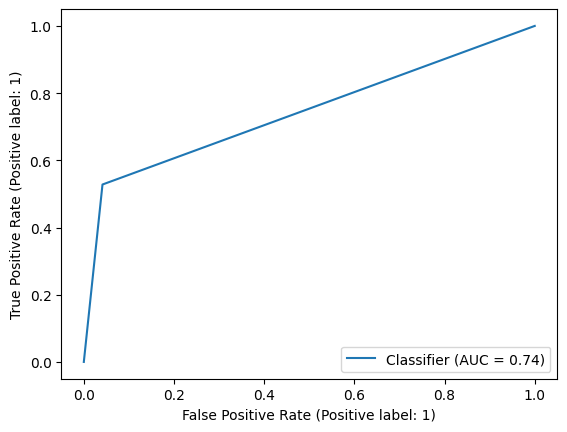

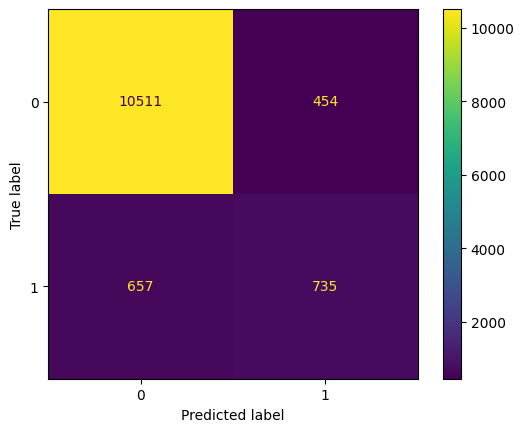

In [13]:
# Inferencia y evaluación
def predict_evaluate(model, X_test, y_test):
  print("Predicciones con el subconjunto de evaluación:")
  y_pred = predict_on_test_data(model, X_test)
  print(y_pred)
  print("Dist. de probabilidades de predicción con el subconjunto de evaluación:")
  y_pred_prob = predict_prob_on_test_data(model, X_test) #model.predict_proba(X_test)
  print(y_pred_prob)
  print("Métricas del modelo:")
  run_metrics = get_metrics(y_test, y_pred, y_pred_prob)
  create_roc_auc_plot(y_test, y_pred)
  create_confusion_matrix_plot(y_test, y_pred, model.classes_)
  
  return run_metrics

run_metrics = predict_evaluate(model, X_test, y_test)

## 3. MLFlow

En la siguiente sección se registraran los experimentos, modelos, parametros y metricas con el módulo `tracking` de mlflow. 

In [56]:
# Función para crear un experimento en MLFlow y registrar parámetros, métricas y archivos de artefactos como imágenes, etc.
def create_experiment(experiment_name,run_name, run_metrics,model, confusion_matrix_path = None,
                      roc_auc_plot_path = None, run_params = None):
    
    mlflow.set_tracking_uri("http://localhost:8080") # Descomentar esta línea si desea usar cualquier base de datos como sqlite como almacenamiento de back-end 
    #mlflow.set_tracking_uri("http://127.0.0.1:5000/") # Descomentar esta línea si desea usar cualquier base de datos como sqlite como almacenamiento de back-end 

    mlflow.set_experiment(experiment_name)

    with mlflow.start_run():

        if not run_params == None:
            for param in run_params:
                mlflow.log_param(param, run_params[param])

        for metric in run_metrics:
            mlflow.log_metric(metric, run_metrics[metric])

        mlflow.sklearn.log_model(model, "model")

        if not confusion_matrix_path == None:
            mlflow.log_artifact(confusion_matrix_path, 'confusion_matrix')

        if not roc_auc_plot_path == None:
            mlflow.log_artifact(roc_auc_plot_path, "roc_auc_plot")

        mlflow.set_tag("tag1", "Random Forest")
        mlflow.set_tags({"tag2":"Randomized Search CV", "tag3":"Production"})

    print('La ejecución: %s fue registrada en el experimento: %s' %(run_name, experiment_name))

Primer experimento con el modelo (básico) de `RandomForest`.  

Valores nan en los datos: age               0
job               0
marital           0
education         0
default           0
housing           0
loan              0
contact           0
month             0
day_of_week       0
duration          0
campaign          0
pdays             0
previous          0
poutcome          0
emp_var_rate      0
cons_price_idx    0
cons_conf_idx     0
euribor3m         0
nr_employed       0
y                 0
dtype: int64
Valores nan después de eliminar filas con datos vacios age               0
job               0
marital           0
education         0
default           0
housing           0
loan              0
contact           0
month             0
day_of_week       0
duration          0
campaign          0
pdays             0
previous          0
poutcome          0
emp_var_rate      0
cons_price_idx    0
cons_conf_idx     0
euribor3m         0
nr_employed       0
y                 0
dtype: int64
Nuevo número de instancias:  51166
Nuevo número de in

MlflowException: API request to http://localhost:8080/api/2.0/mlflow/experiments/get-by-name failed with exception HTTPConnectionPool(host='localhost', port=8080): Max retries exceeded with url: /api/2.0/mlflow/experiments/get-by-name?experiment_name=clasificador_basico (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x0000014627C6F790>: Failed to establish a new connection: [WinError 10061] No se puede establecer una conexión ya que el equipo de destino denegó expresamente dicha conexión'))

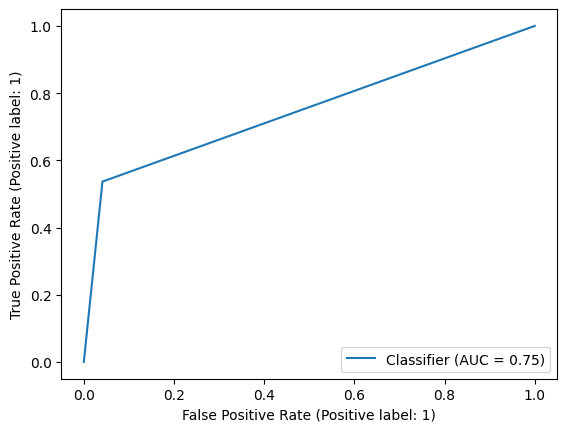

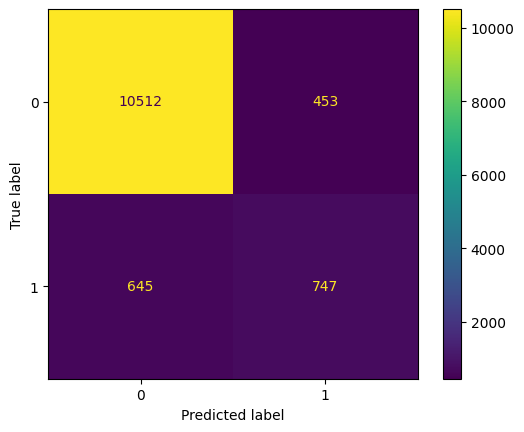

In [57]:
experiment_name = "clasificador_basico"
run_name = "smote_aplicado"

model, X_train, X_test, y_train, y_test = preprocess_train('banking.csv')
run_metrics = predict_evaluate(model, X_test, y_test)
print(run_metrics)

create_experiment(experiment_name, # Nombre del experimento
                  run_name, # Nombre de la ejecución
                  run_metrics, # Métricas obtenidas
                  model, # Modelo ajustado
                  'confusion_matrix.png', # Ruta a la imagen de la mátriz de confusión
                  'roc_auc_curve.png', # Ruta a la imagen de la gráfica AUC
                  run_params = {"n_estimators":101} # Parametros utilizados al entrenar el modelo
                 )

Crear otro experimento después de ajustar los hiperparámetros y registrar el mejor conjunto de parámetros encontrados con la función `hyper_parameter_tuning`.

In [ ]:
experiment_name = "modelo_optimizado"
run_name="modelo_tuneado_con_randomsearchcv"

model_tuned, best_params = hyper_parameter_tuning(X_train, y_train)

# Mostrar mejores párametros
for param in best_params:
    print(param, best_params[param])

run_metrics = predict_evaluate(model, X_test, y_test)
print(run_metrics)

create_experiment(experiment_name, # Nombre del experimento
                  run_name, # Nombre de la ejecución
                  run_metrics, # Métricas obtenidas
                  model_tuned, # Modelo ajustado
                  'confusion_matrix.png', # Ruta a la imagen de la mátriz de confusión
                  'roc_auc_curve.png', # Ruta a la imagen de la gráfica AUC
                  run_params = best_params # Parametros encontrados con Random Search CV
                 )

## 4. Model Registry

Si se desea utilizar la función Model Registry, necesitamos una base de datos que apoye el registro. Las opciones de base de datos son `oracle`, `mysql`, `postgresql`, `sqlite`. En esta sección veremos la configuración para `mysql` y `sqlite`, siendo esta última la mas facil de configurar. 

#### Usando MySQL

1. Crear una base de datos nueva para MLflow.

`CREATE DATABASE mlflow_tracking_database;`

2. Inicilizar el servidor de tracking de MLflow utilizando la base de datos MySQL.
` mlflow server \
   --backend-store-uri  mysql+pymysql://root@localhost/mlflow_tracking_database \
   --default-artifact-root  file:/./mlruns \
   -h 0.0.0.0 -p 8080`


3. Establecer el URI de seguimiento de MLflow (dentro de la sección de código).

  mlflow.set_tracking_uri("http://localhost:8080")

#### Usando SQLite

1. Inicilizar el servidor de tracking de MLflow utilizando una base de datos SQLite.

`mlflow server --backend-store-uri sqlite:///mlflow.db --default-artifact-root ./artifacts --host 0.0.0.0 --port 8080`


2. Establecer el URI de seguimiento de MLflow (dentro de la sección de código).
    
    mlflow.set_tracking_uri("http://localhost:8080")

Ref. https://www.mlflow.org/docs/latest/model-registry.html#model-registry-workflows

### 4.1 Agregar modelos a Model Registry: Método 1

Ref.: https://www.mlflow.org/docs/latest/model-registry.html

Hay tres formas para agregar un modelo al Model Registry con código. Primero, puede usar el método mlflow.`<model>.log_model()`. La siguiente función aplica esta estrategía:

Valores nan en los datos: age               0
job               0
marital           0
education         0
default           0
housing           0
loan              0
contact           0
month             0
day_of_week       0
duration          0
campaign          0
pdays             0
previous          0
poutcome          0
emp_var_rate      0
cons_price_idx    0
cons_conf_idx     0
euribor3m         0
nr_employed       0
y                 0
dtype: int64
Valores nan después de eliminar filas con datos vacios age               0
job               0
marital           0
education         0
default           0
housing           0
loan              0
contact           0
month             0
day_of_week       0
duration          0
campaign          0
pdays             0
previous          0
poutcome          0
emp_var_rate      0
cons_price_idx    0
cons_conf_idx     0
euribor3m         0
nr_employed       0
y                 0
dtype: int64
Nuevo número de instancias:  51166
Nuevo número de in

MlflowException: API request to http://localhost:8080/api/2.0/mlflow/experiments/get-by-name failed with exception HTTPConnectionPool(host='localhost', port=8080): Max retries exceeded with url: /api/2.0/mlflow/experiments/get-by-name?experiment_name=clasificador_basico_model_registry (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x0000014627DEF280>: Failed to establish a new connection: [WinError 10061] No se puede establecer una conexión ya que el equipo de destino denegó expresamente dicha conexión'))

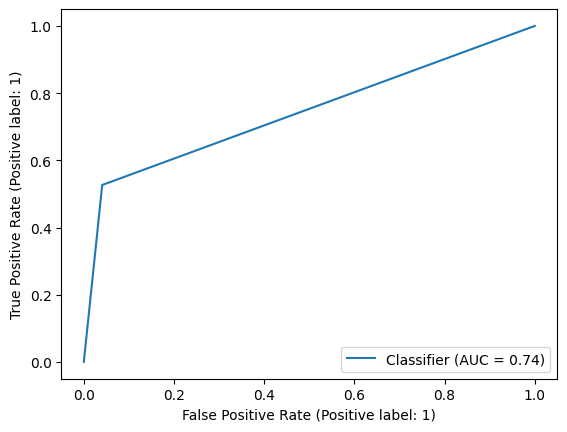

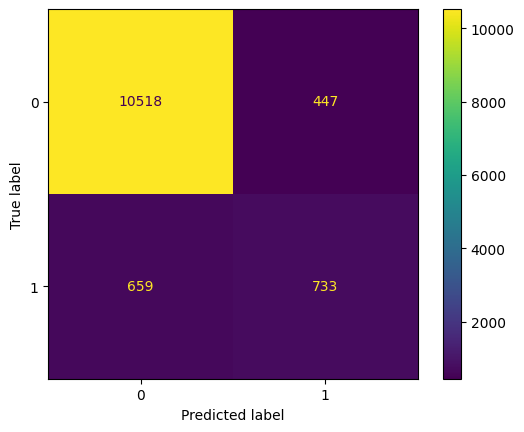

In [58]:
def create_exp_and_register_model(experiment_name,run_name,run_metrics,model,confusion_matrix_path = None, 
                      roc_auc_plot_path = None, run_params=None):
  
    mlflow.set_tracking_uri("http://localhost:8080") 
    # mlflow.set_tracking_uri("127.0.0.1:5000") 

    mlflow.set_experiment(experiment_name)
    
    with mlflow.start_run(run_name=run_name) as run:
        if not run_params == None:
            for param in run_params:
                mlflow.log_param(param, run_params[param])

        for metric in run_metrics:
            mlflow.log_metric(metric, run_metrics[metric])

        if not confusion_matrix_path == None:
            mlflow.log_artifact(confusion_matrix_path, 'confusion_matrix')

        if not roc_auc_plot_path == None:
            mlflow.log_artifact(roc_auc_plot_path, "roc_auc_plot")

        mlflow.set_tag("tag1", "Random Forest")
        mlflow.set_tags({"tag2":"Randomized Search CV", "tag3":"Production"})
        
        # Incluimos esta linea
        mlflow.sklearn.log_model(model, "model",registered_model_name="randomforest-classifier")
        
experiment_name = "clasificador_basico_model_registry"
run_name = "smote_aplicado"

model, X_train, X_test, y_train, y_test = preprocess_train('banking.csv')
run_metrics = predict_evaluate(model, X_test, y_test)
print(run_metrics)

create_exp_and_register_model(experiment_name, # Nombre del experimento
                  run_name, # Nombre de la ejecución
                  run_metrics, # Métricas obtenidas
                  model, # Modelo ajustado
                  'confusion_matrix.png', # Ruta a la imagen de la mátriz de confusión
                  'roc_auc_curve.png', # Ruta a la imagen de la gráfica AUC
                  run_params = {"n_estimators":101} # Parametros utilizados al entrenar el modelo
                 )

En el fragmento de código anterior, si no existe un modelo registrado con el nombre especificado, el método registrara un nuevo modelo y crea la Versión 1. Si existe un modelo registrado con el nombre, el método creara una nueva versión del modelo.

### 4.2 Agregar modelos a Model Registry: Método 2

La segunda forma es usando el método `mlflow.register_model()`, después de que se complete todo el experimento y cuando haya decidido qué modelo es el más adecuado para agregar a Model Registry. Para este método, necesitará el run_id como parte del argumento runs:URI.

In [ ]:
with mlflow.start_run(run_name="prueba") as run:
    result = mlflow.register_model(
        "runs:/be1435f08eef4445b73473168f827b80/model",
        "random_forest_optimizado"
    )

Si no existe un modelo registrado con el nombre, el método registra un nuevo modelo, crea la Versión 1 y devuelve un objeto `ModelVersion` de MLflow. Si existe un modelo registrado con el nombre, el método crea una nueva versión del modelo y devuelve el objeto de la versión.

### 4.3 Inferencia con un modelo de MLflow desde Model Registry

In [ ]:
import mlflow.pyfunc

model_name = "random_forest_optimizado"
model_version = 1

model = mlflow.pyfunc.load_model(
    model_uri=f"models:/{model_name}/{model_version}"
)

y_pred = model.predict(X_test)
print(y_pred)

sklearn_model = mlflow.sklearn.load_model(
    model_uri=f"models:/{model_name}/{model_version}"
)
y_pred_prob = sklearn_model.predict_proba(X_test)
print(y_pred_prob)

client = mlflow.tracking.MlflowClient()
client.transition_model_version_stage(
    name="iris-classifier",
    version=1,
    stage="Production"
)

### 4.4 Transicionar un modelo a diferentes estapas Stage

In [59]:
client = mlflow.tracking.MlflowClient()
client.transition_model_version_stage(
    name="randomforest-classifier",
    version=1,
    stage="Production"
)

MlflowException: API request to http://localhost:8080/api/2.0/mlflow/model-versions/transition-stage failed with exception HTTPConnectionPool(host='localhost', port=8080): Max retries exceeded with url: /api/2.0/mlflow/model-versions/transition-stage (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x000001462815A4C0>: Failed to establish a new connection: [WinError 10061] No se puede establecer una conexión ya que el equipo de destino denegó expresamente dicha conexión'))

In [19]:
# Obtener el modelo, desde la etapa de producción, para realizar predicciones
import mlflow.pyfunc

model_name = "randomforest-classifier"
stage = 'Production'

model = mlflow.pyfunc.load_model(
    model_uri=f"models:/{model_name}/{stage}"
)

y_pred = model.predict(X_test)
print(y_pred)

MlflowException: API request to http://localhost:8080/api/2.0/mlflow/registered-models/get-latest-versions failed with exception HTTPConnectionPool(host='localhost', port=8080): Max retries exceeded with url: /api/2.0/mlflow/registered-models/get-latest-versions (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x0000012A1DA6D460>: Failed to establish a new connection: [WinError 10061] No se puede establecer una conexión ya que el equipo de destino denegó expresamente dicha conexión'))

#### Ejercicio 1: Realizar inferencia con el modelo usando solamente una instancia

In [36]:
# import mlflow.pyfunc

# model_name = "random_forest_optimizado"
# stage = 'Production'

# model = mlflow.sklearn.load_model(
#     model_uri=f"models:/{model_name}/{stage}"
# )

# y_pred = model.predict([[Pasar aqui los atributos]])
# print(y_pred)

# y_pred_prob = model.predict_proba([[Pasar aqui los atributos]])
# print(y_pred_prob)

## 5. MLFlow Models

MLFlow permite desplegar modelos facilmente con MLFlow Models. Para esto, necesitaremos registrar 

In [44]:
protocol = "http"
host = "localhost"
port = "8080"
URI = f"{protocol}://{host}:{port}"

mlflow.set_tracking_uri(URI)

Agregar la variable de entorno

In [45]:
!export MLFLOW_TRACKING_URI=URI
!source ~/.zshrc # o !source ~/.bash_profile si así lo requiere el sistema operativo 

Siguiente, sera necesario ejecutar un nuevo servicio, especificando un puerto diferente: 
`mlflow models serve --model-uri models:/random_forest_optimizado/Production -p 1234 --no-conda`

In [47]:
# import requests

# inference_request = {
#         "dataframe_records": [["pasar datos de un nuevo registro aqui"]]
# }

# endpoint = "http://localhost:1234/invocations"

# response = requests.post(endpoint, json=inference_request)

# print(response.text)

#### Ejercicio 2: Calidad del vino 

Versionar los experimentos de su modelo de clasificación de calidad del vino basado en Scikit-Learn. Desplegar el mejor modelo a producción y realizar una solicitud hacia el API de MLFlow Models, usando nuevos datos.  